### Robust Asset Allocation - Aggressive: Detailed Implementation and Explanation

The Robust Asset Allocation - Aggressive strategy dynamically adjusts asset allocations to maximize returns while managing risk, using recent performance metrics and moving averages to identify potential turning points. Here's a detailed explanation of the strategy and its implementation.

1. **Asset Selection**
2. **Return Calculation**
3. **Allocation Adjustment**
4. **Risk Management**

#### 1. Asset Selection

The portfolio consists of the following assets:

| Ticker | Asset Class                    | Weight |
|--------|--------------------------------|--------|
| MTUM   | US Momentum                    | 20%    |
| IWD    | US Large Cap Value             | 20%    |
| EFA    | International Equities         | 20%    |
| EFV    | International Value            | 20%    |
| VNQ    | REITs                          | 5%     |
| DBC    | Commodities                    | 5%     |
| IEF    | Intermediate-Term US Treasuries| 10%    |

These assets are chosen to provide diversification across different asset classes and investment styles.

#### 2. Return Calculation

The strategy uses both trailing returns and moving averages to determine allocations. Trailing returns capture the recent performance of an asset, while moving averages help identify trends and potential turning points.

- **Trailing 12-Month Returns** ($ R_{i,t}^{(12)} $):

$ R_{i,t}^{(12)} = \frac{P_{i,t}}{P_{i,t-12}} - 1 $

- **12-Month Moving Average** ($ MA_{i,t}^{(12)} $):

$ MA_{i,t}^{(12)} = \frac{1}{12} \sum_{k=0}^{11} P_{i,t-k} $

Using both metrics allows the strategy to balance momentum with trend-following, reducing exposure to assets that might be nearing a potential turning point.

#### 3. Allocation Adjustment

The allocation for each asset is determined based on its trailing returns and its position relative to its moving average:

1. On the last trading day of the month, determine:
    - Is the 12-month return of the asset greater than the 12-month return of BIL?
    - Is the closing price greater than the 12-month moving average?

2. If the answer is 'yes' for both, invest 100% in the asset.
    - If the answer is 'yes' for only one, invest 50% in the asset and 50% in cash.
    - If the answer is 'no' for both, invest that portion of the portfolio in cash.

3. Hold all positions until the last trading day of the following month.

Formally:

$ w_{i,t} = \begin{cases} 
1 & \text{if } R_{i,t}^{(12)} > 0 \text{ and } P_{i,t} > MA_{i,t}^{(12)} \\
0.5 & \text{if } R_{i,t}^{(12)} > 0 \text{ or } P_{i,t} > MA_{i,t}^{(12)} \\
0 & \text{otherwise}
\end{cases} $

The unallocated weight is assigned to the risk-free asset (BIL):

$ w_{BIL,t} = 1 - \sum_{i=1}^{N} w_{i,t} $


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio as pf

/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


[*********************100%%**********************]  8 of 8 completed


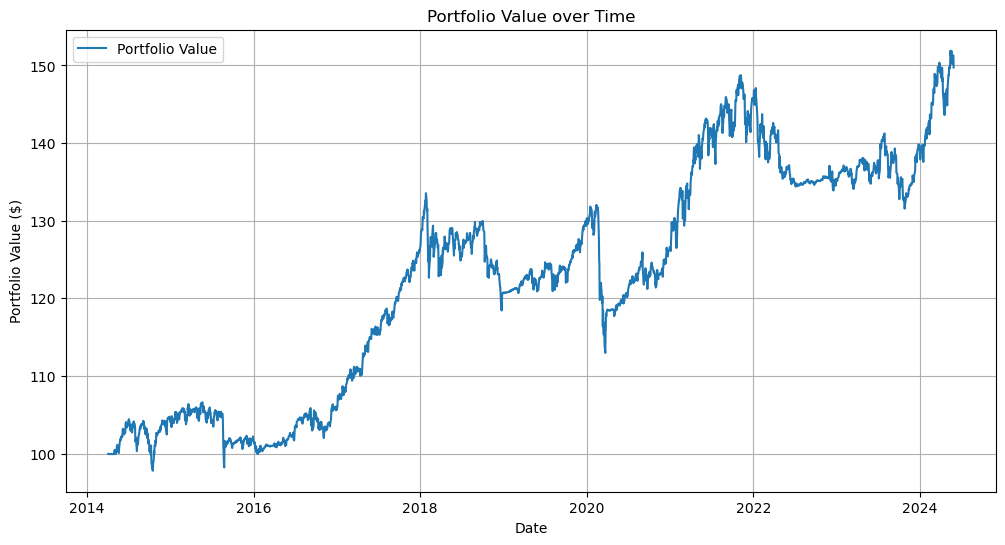

In [7]:
# Define the portfolio including BIL
portfolio = {
    'MTUM': 0.2,
    'IWD': 0.2,
    'EFA': 0.2,
    'EFV': 0.2,
    'VNQ': 0.05,
    'DBC': 0.05,
    'IEF': 0.1,
    'BIL': 0.0  # BIL as the risk-free asset
}

# Download historical data
data = yf.download(list(portfolio.keys()), start='2013-01-01')['Adj Close']
monthly_data = data.resample('M').last()
trailing_returns_12m = monthly_data.pct_change(periods=12).dropna()
moving_avg_12m = monthly_data.rolling(window=12).mean().dropna()
BIL_returns_12m = trailing_returns_12m['BIL']

# Initialize allocations DataFrame
allocations = pd.DataFrame(index=monthly_data.index, columns=monthly_data.columns)

# Allocation logic
for asset in portfolio.keys():
    for date in allocations.index:
        if date not in trailing_returns_12m.index or date not in moving_avg_12m.index:
            continue
        if asset == 'BIL':
            allocations.loc[date, asset] = 0.0
        elif trailing_returns_12m.loc[date, asset] > BIL_returns_12m[date] and monthly_data.loc[date, asset] > moving_avg_12m.loc[date, asset]:
            allocations.loc[date, asset] = 1.0
        elif trailing_returns_12m.loc[date, asset] > BIL_returns_12m[date] or monthly_data.loc[date, asset] > moving_avg_12m.loc[date, asset]:
            allocations.loc[date, asset] = 0.5
        else:
            allocations.loc[date, asset] = 0.0

allocations = allocations.fillna(0.0)
portfolio_allocations = allocations.multiply(pd.Series(portfolio), axis=1)
portfolio_allocations['BIL'] = 1.0 - portfolio_allocations.sum(axis=1)

# Forward fill the portfolio allocations to match the data frequency
portfolio_allocations_filled = portfolio_allocations.reindex(data.index, method='ffill').fillna(0.0)

# Append the filled allocations to the original data DataFrame
combined_data = data.join(portfolio_allocations_filled, rsuffix='_allocation')

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Extract and align allocations
allocation_columns = [col for col in combined_data.columns if '_allocation' in col]
allocations = combined_data[allocation_columns]
allocations.columns = [col.replace('_allocation', '') for col in allocations.columns]

# Calculate weighted returns and portfolio returns
weighted_returns = daily_returns * allocations
portfolio_returns = weighted_returns.sum(axis=1)

# Calculate cumulative portfolio value
initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[315:], label='Portfolio Value')
plt.title('Portfolio Value over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


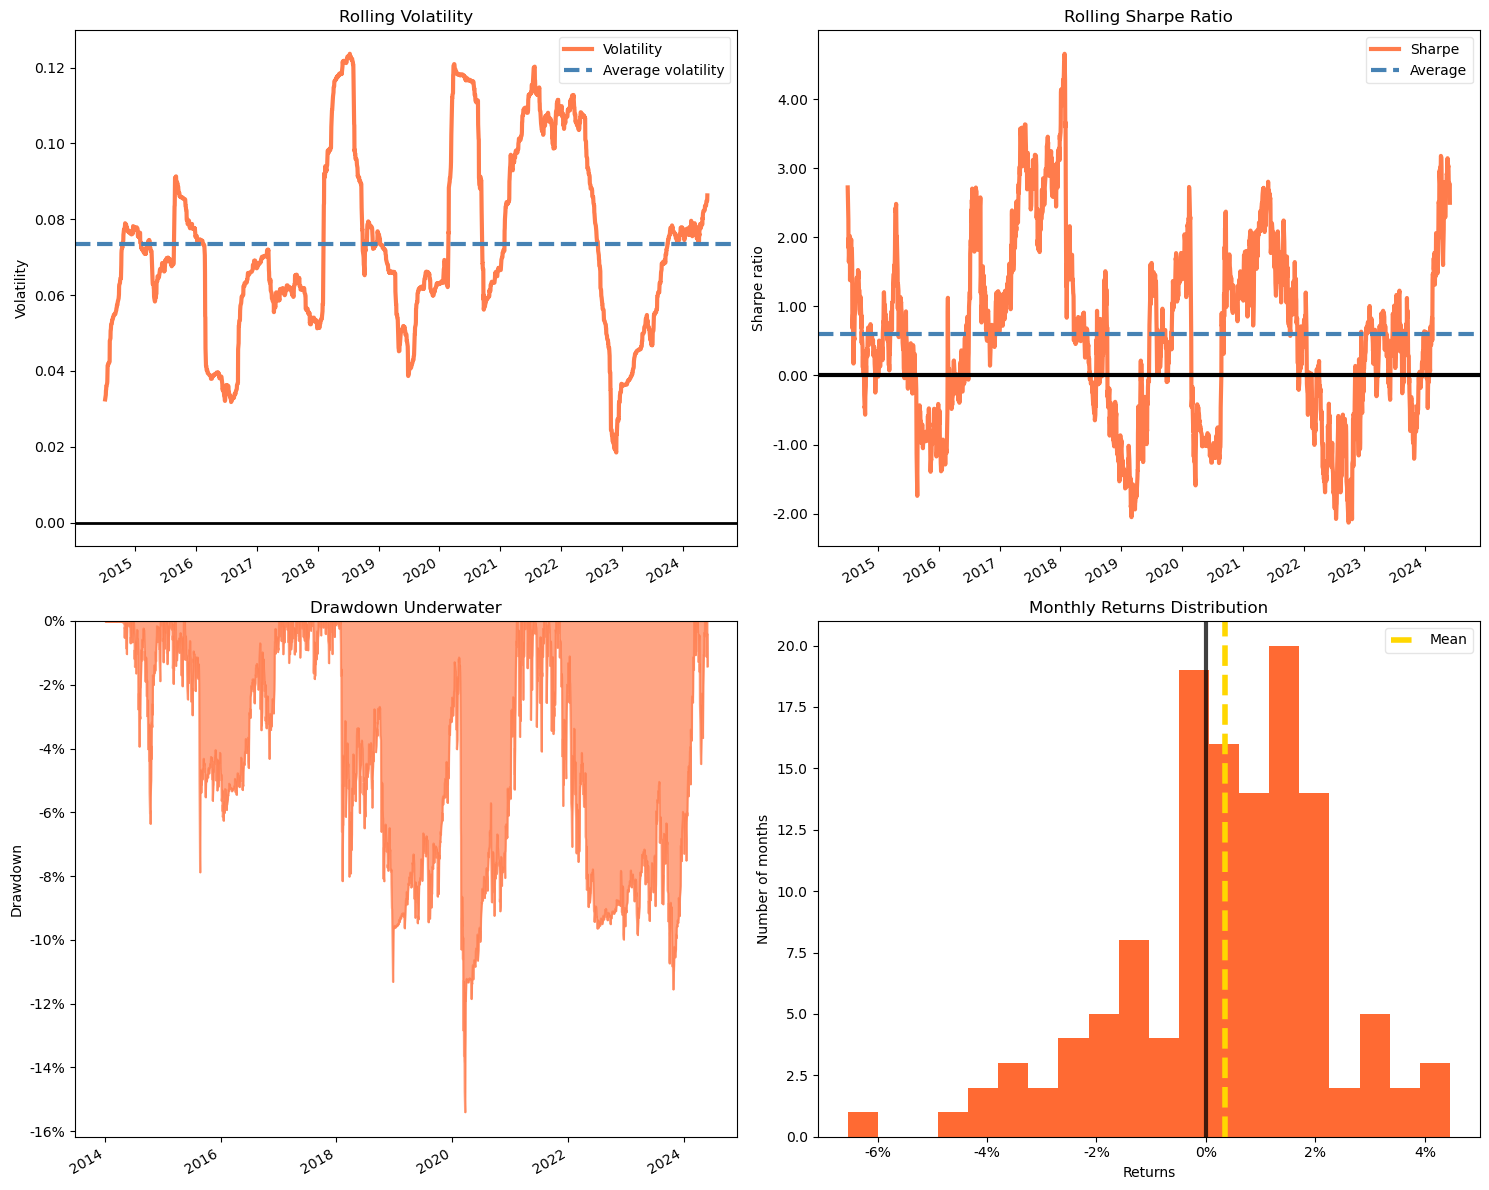

In [8]:
strategy_returns = portfolio_value[252:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_dist(strategy_returns, ax=axs[1, 1])
axs[1, 1].set_title('Monthly Returns Distribution')

plt.tight_layout()
plt.show()

[*********************100%%**********************]  8 of 8 completed


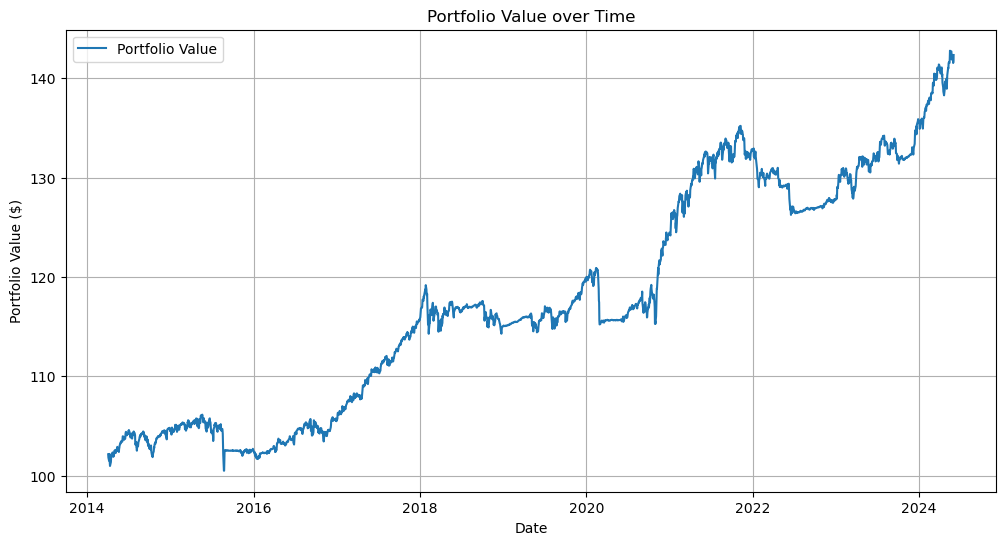

In [6]:
# Define the portfolio including BIL
portfolio = {
    'MTUM': 0.2,
    'IWD': 0.2,
    'EFA': 0.2,
    'EFV': 0.2,
    'VNQ': 0.05,
    'DBC': 0.05,
    'IEF': 0.1,
    'BIL': 0.0  # BIL as the risk-free asset
}

# Download historical data
data = yf.download(list(portfolio.keys()), start='2013-01-01')['Adj Close']
monthly_data = data.resample('M').last()
trailing_returns_12m = monthly_data.pct_change(periods=6).dropna()
moving_avg_12m = monthly_data.rolling(window=1).mean().dropna()
BIL_returns_12m = trailing_returns_12m['BIL']

# Initialize allocations DataFrame
allocations = pd.DataFrame(index=monthly_data.index, columns=monthly_data.columns)

# Allocation logic
for asset in portfolio.keys():
    for date in allocations.index:
        if date not in trailing_returns_12m.index or date not in moving_avg_12m.index:
            continue
        if asset == 'BIL':
            allocations.loc[date, asset] = 0.0
        elif trailing_returns_12m.loc[date, asset] > BIL_returns_12m[date] and monthly_data.loc[date, asset] > moving_avg_12m.loc[date, asset]:
            allocations.loc[date, asset] = 1.0
        elif trailing_returns_12m.loc[date, asset] > BIL_returns_12m[date] or monthly_data.loc[date, asset] > moving_avg_12m.loc[date, asset]:
            allocations.loc[date, asset] = 0.5
        else:
            allocations.loc[date, asset] = 0.0

allocations = allocations.fillna(0.0)
portfolio_allocations = allocations.multiply(pd.Series(portfolio), axis=1)
portfolio_allocations['BIL'] = 1.0 - portfolio_allocations.sum(axis=1)

# Forward fill the portfolio allocations to match the data frequency
portfolio_allocations_filled = portfolio_allocations.reindex(data.index, method='ffill').fillna(0.0)

# Append the filled allocations to the original data DataFrame
combined_data = data.join(portfolio_allocations_filled, rsuffix='_allocation')

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Extract and align allocations
allocation_columns = [col for col in combined_data.columns if '_allocation' in col]
allocations = combined_data[allocation_columns]
allocations.columns = [col.replace('_allocation', '') for col in allocations.columns]

# Calculate weighted returns and portfolio returns
weighted_returns = daily_returns * allocations
portfolio_returns = weighted_returns.sum(axis=1)

# Calculate cumulative portfolio value
initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[315:], label='Portfolio Value')
plt.title('Portfolio Value over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  8 of 8 completed


Best Lookback Period: 6 months
Best Moving Average Period: 1 months
Best Sharpe Ratio: 0.8181375335846568


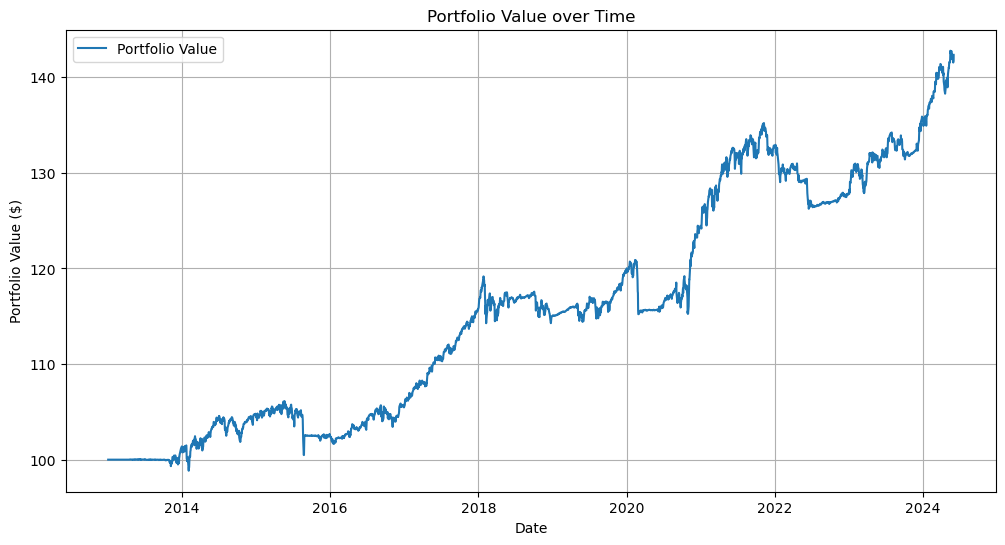

In [5]:
# Define the portfolio including BIL
portfolio = {
    'MTUM': 0.2,
    'IWD': 0.2,
    'EFA': 0.2,
    'EFV': 0.2,
    'VNQ': 0.05,
    'DBC': 0.05,
    'IEF': 0.1,
    'BIL': 0.0  # BIL as the risk-free asset
}

# Download historical data
data = yf.download(list(portfolio.keys()), start='2013-01-01')['Adj Close']
monthly_data = data.resample('M').last()

# Define ranges for lookback and moving average periods
lookback_periods = [1, 3, 6, 9, 12]  # 6 months, 9 months, 12 months
moving_avg_periods = [1, 3, 6, 9, 12]  # 6 months, 9 months, 12 months

# Function to apply the strategy and calculate the portfolio value
def apply_strategy(lookback_period, moving_avg_period):
    trailing_returns = monthly_data.pct_change(periods=lookback_period).dropna()
    moving_avg = monthly_data.rolling(window=moving_avg_period).mean().dropna()
    BIL_returns = trailing_returns['BIL']
    
    # Initialize allocations DataFrame
    allocations = pd.DataFrame(index=monthly_data.index, columns=monthly_data.columns)
    
    # Allocation logic
    for asset in portfolio.keys():
        for date in allocations.index:
            if date not in trailing_returns.index or date not in moving_avg.index:
                continue
            if asset == 'BIL':
                allocations.loc[date, asset] = 0.0
            elif trailing_returns.loc[date, asset] > BIL_returns[date] and monthly_data.loc[date, asset] > moving_avg.loc[date, asset]:
                allocations.loc[date, asset] = 1.0
            elif trailing_returns.loc[date, asset] > BIL_returns[date] or monthly_data.loc[date, asset] > moving_avg.loc[date, asset]:
                allocations.loc[date, asset] = 0.5
            else:
                allocations.loc[date, asset] = 0.0
    
    allocations = allocations.fillna(0.0)
    portfolio_allocations = allocations.multiply(pd.Series(portfolio), axis=1)
    portfolio_allocations['BIL'] = 1.0 - portfolio_allocations.sum(axis=1)
    
    # Forward fill the portfolio allocations to match the data frequency
    portfolio_allocations_filled = portfolio_allocations.reindex(data.index, method='ffill').fillna(0.0)
    
    # Calculate daily returns
    daily_returns = data.pct_change().dropna()
    
    # Extract and align allocations
    allocation_columns = [col for col in portfolio_allocations_filled.columns if col in daily_returns.columns]
    allocations = portfolio_allocations_filled[allocation_columns]
    
    # Calculate weighted returns and portfolio returns
    weighted_returns = daily_returns * allocations
    portfolio_returns = weighted_returns.sum(axis=1)
    
    # Calculate cumulative portfolio value
    initial_investment = 100
    portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment
    
    # Calculate Sharpe ratio
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
    
    return sharpe_ratio, portfolio_value

# Perform grid search
results = []

for lookback, moving_avg in product(lookback_periods, moving_avg_periods):
    sharpe_ratio, portfolio_value = apply_strategy(lookback, moving_avg)
    results.append((lookback, moving_avg, sharpe_ratio, portfolio_value))

# Find the best parameters
best_result = max(results, key=lambda x: x[2])
best_lookback, best_moving_avg, best_sharpe_ratio, best_portfolio_value = best_result

# Print the best parameters
print(f"Best Lookback Period: {best_lookback} months")
print(f"Best Moving Average Period: {best_moving_avg} months")
print(f"Best Sharpe Ratio: {best_sharpe_ratio}")

# Plot the portfolio value using the best parameters
plt.figure(figsize=(12, 6))
plt.plot(best_portfolio_value, label='Portfolio Value')
plt.title('Portfolio Value over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  28 of 28 completed


Best Lookback Period: 6 months
Best Moving Average Period: 1 months
Best Sharpe Ratio: 0.7770242332160666


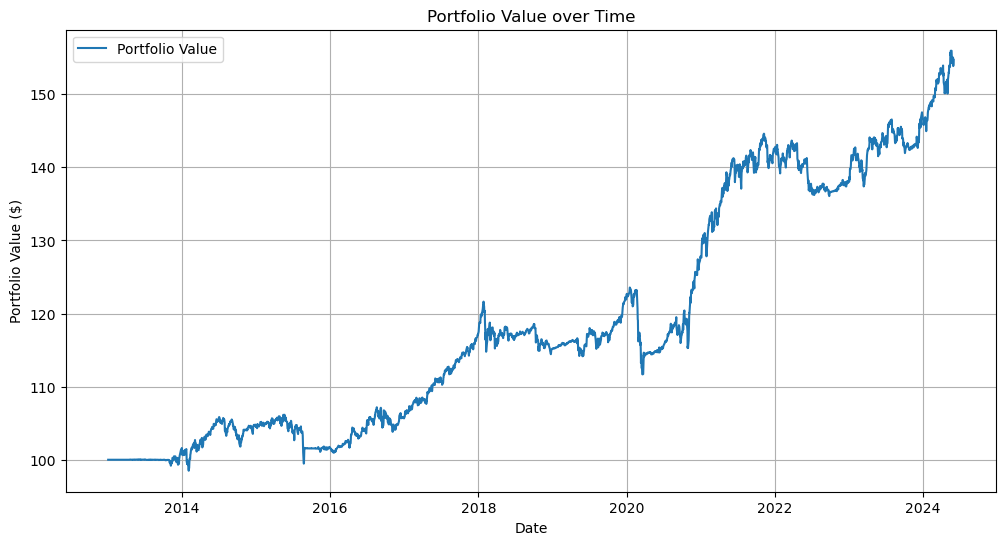

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define the portfolio including additional ETFs
portfolio = {
    'MTUM': 0.1,
    'IWD': 0.1,
    'EFA': 0.1,
    'EFV': 0.1,
    'VNQ': 0.05,
    'DBC': 0.05,
    'IEF': 0.05,
    'BIL': 0.0,  # BIL as the risk-free asset
    'VEA': 0.05,
    'VWO': 0.05,
    'EWJ': 0.05,
    'EWU': 0.05,
    'EWG': 0.05,
    'EWW': 0.05,
    'EWL': 0.05,
    'EWA': 0.05,
    'XLF': 0.05,
    'XLK': 0.05,
    'XLE': 0.05,
    'XLV': 0.05,
    'GLD': 0.05,
    'SLV': 0.05,
    'USO': 0.05,
    'DBA': 0.05,
    'TLT': 0.05,
    'TIP': 0.05,
    'LQD': 0.05,
    'HYG': 0.05
}

# Download historical data
data = yf.download(list(portfolio.keys()), start='2013-01-01')['Adj Close']
monthly_data = data.resample('M').last()

# Define ranges for lookback and moving average periods
lookback_periods = [1, 3, 6, 9, 12]  # 6 months, 9 months, 12 months
moving_avg_periods = [1, 3, 6, 9, 12]  # 6 months, 9 months, 12 months

# Function to apply the strategy and calculate the portfolio value
def apply_strategy(lookback_period, moving_avg_period):
    trailing_returns = monthly_data.pct_change(periods=lookback_period).dropna()
    moving_avg = monthly_data.rolling(window=moving_avg_period).mean().dropna()
    BIL_returns = trailing_returns['BIL']
    
    # Initialize allocations DataFrame
    allocations = pd.DataFrame(index=monthly_data.index, columns=monthly_data.columns)
    
    # Allocation logic
    for asset in portfolio.keys():
        for date in allocations.index:
            if date not in trailing_returns.index or date not in moving_avg.index:
                continue
            if asset == 'BIL':
                allocations.loc[date, asset] = 0.0
            elif trailing_returns.loc[date, asset] > BIL_returns[date] and monthly_data.loc[date, asset] > moving_avg.loc[date, asset]:
                allocations.loc[date, asset] = 1.0
            elif trailing_returns.loc[date, asset] > BIL_returns[date] or monthly_data.loc[date, asset] > moving_avg.loc[date, asset]:
                allocations.loc[date, asset] = 0.5
            else:
                allocations.loc[date, asset] = 0.0
    
    allocations = allocations.fillna(0.0)
    portfolio_allocations = allocations.multiply(pd.Series(portfolio), axis=1)
    portfolio_allocations['BIL'] = 1.0 - portfolio_allocations.sum(axis=1)
    
    # Forward fill the portfolio allocations to match the data frequency
    portfolio_allocations_filled = portfolio_allocations.reindex(data.index, method='ffill').fillna(0.0)
    
    # Calculate daily returns
    daily_returns = data.pct_change().dropna()
    
    # Extract and align allocations
    allocation_columns = [col for col in portfolio_allocations_filled.columns if col in daily_returns.columns]
    allocations = portfolio_allocations_filled[allocation_columns]
    
    # Calculate weighted returns and portfolio returns
    weighted_returns = daily_returns * allocations
    portfolio_returns = weighted_returns.sum(axis=1)
    
    # Calculate cumulative portfolio value
    initial_investment = 100
    portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment
    
    # Calculate Sharpe ratio
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
    
    return sharpe_ratio, portfolio_value

# Perform grid search
results = []

for lookback, moving_avg in product(lookback_periods, moving_avg_periods):
    sharpe_ratio, portfolio_value = apply_strategy(lookback, moving_avg)
    results.append((lookback, moving_avg, sharpe_ratio, portfolio_value))

# Find the best parameters
best_result = max(results, key=lambda x: x[2])
best_lookback, best_moving_avg, best_sharpe_ratio, best_portfolio_value = best_result

# Print the best parameters
print(f"Best Lookback Period: {best_lookback} months")
print(f"Best Moving Average Period: {best_moving_avg} months")
print(f"Best Sharpe Ratio: {best_sharpe_ratio}")

# Plot the portfolio value using the best parameters
plt.figure(figsize=(12, 6))
plt.plot(best_portfolio_value, label='Portfolio Value')
plt.title('Portfolio Value over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()
